# Introduction to NLP Fundamentals in TensorFlow

NLP has the goal of deriving information out of natural language (could be sequences or speech).

Another common term for NLP problems is sequence to sequence (seq2seq).

## Get helper functions


In [ ]:
!wget https://raw.githubusercontent.com/JoachimLombardi/Helper_functions/master/course_ztm.py

# Import a series of helper functions for the notebook
from course_ztm import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys

--2023-05-30 13:29:49--  https://raw.githubusercontent.com/JoachimLombardi/Helper_functions/master/course_ztm.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11447 (11K) [text/plain]
Saving to: ‘course_ztm.py’

course_ztm.py       100%[===================>]  11.18K  --.-KB/s    in 0s      

2023-05-30 13:29:49 (98.9 MB/s) - ‘course_ztm.py’ saved [11447/11447]



## Get a text dataset

The dataset we're going to be using is Kaggle's introduction to NLP dataset (text samples of Tweets labelled as disaster or not disaster).

See the original source here:https://www.kaggle.com/competitions/nlp-getting-started

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip

# Unzip data
unzip_data("nlp_getting_started.zip")

--2023-05-30 13:29:53--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.251.18.128, 142.250.153.128, 142.250.145.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.251.18.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  1.27MB/s    in 0.5s    

2023-05-30 13:29:53 (1.27 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



## Visualizing a text dataset

To visualize our text samples, we first have to read them in,  one way to do so would be to use Python: https://realpython.com/read-write-files-python/
But I prefer to get visual straight away.
So another way to do this is to use pandas...

In [ ]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv", index_col=0)
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
# Shuffle training data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [ ]:
# What does the test dataframe look like ?
test_df.head()

,keyword,location,text
id,,,
0,NaN,NaN,Just happened a terrible car crash
2,NaN,NaN,"Heard about #earthquake is different cities, s..."
3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [ ]:
# How many examples of each class ?
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [ ]:
# How many total samples ?
len(train_df), len(test_df)

(7613, 3263)

In [ ]:
# Let's visualize some random training examples
import random
random_index = random.randint(0, (len(train_df)-5)) # Create random indexes not higher than the total of samples
for row in train_df_shuffled[["text", "target"]][random_index:random_index+5].itertuples(): # Return tuples of text and target
  _, text, target = row
  print(f"Target: {target}", "(real disaster)" if target > 0 else "(not real disaster)")
  print(f"Text:\n{text}\n")
  print("---\n")

Target: 1 (real disaster)
Text:
SEISMIC RISK: a COMPARISON between 2 case studies: CALABRIA AND MALTA http://t.co/HmRtqEykyI

---

Target: 0 (not real disaster)
Text:
The Eden Hazard of Hockey https://t.co/RbbnjkoqUD

---

Target: 0 (not real disaster)
Text:
Check out this awesome profile on #GE's swimming #robot used in #nuclear reactors! http://t.co/HRc3oxQUIK #innovation http://t.co/wNPTvbM5T7

---

Target: 1 (real disaster)
Text:
A young German stormtrooper engaged in the Battle of the Somme 1916. [800 ÌÑ 582 ] http://t.co/yxvMifLvc4

---

Target: 1 (real disaster)
Text:
California cops have sketch of gunman who killed one wounded two deputies via the @FoxNews app http://t.co/3Ife1zsop7

---



### Split data into training and validation sets


In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(), # As numpy's array
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # Use 10% of the training data for validation split
                                                                            random_state=42)

In [ ]:
# Check the lenghts 
len(train_sentences), len(train_labels), len(val_sentences), len(val_labels)

(6851, 6851, 762, 762)

In [ ]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

## Convert text into numbers 

When dealing with a text problem, one of the first things you'll have to do before you can build a model is to convert your text to numbers.

There are a few ways to do this, namely:
* Tokenization - direct mapping of token (a token could be a word or a character) to number.
* Embedding - create a matrix of feature vector for each token
(the size of the feature vector can be defined and this embedding can be learned)  

### Text vectorization (tokenization)

In [ ]:
train_sentences[:5]

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
       'Somehow find you and I collide http://t.co/Ee8RpOahPk'],
      dtype=object)

In [ ]:
import tensorflow as tf 
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

# Use the default TextVectorization parameters
text_vectorizer = TextVectorization(max_tokens=10000, # how many words in the vocabulary (automatically add <OOV> (Out Of Vacabulary) to replace a rare word (e.g 10000 means picks 10000 most common words to turn into numbers))
                                    standardize="lower_and_strip_punctuation",
                                    split="whitespace",
                                    ngrams=None, # create groups of n-words 1 by default
                                    output_mode="int", # how to map tokens to numbers
                                    output_sequence_length=None, # how long do you want your sequences to be like batch 
                                    pad_to_max_tokens=True # the longest by default and fill with 0 for the other
                                    )

In [ ]:
len(train_sentences[0].split())

7

In [ ]:
# Find the average number of tokens (words) in the training tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))

15

In [ ]:
# Setup text vectorization variables 
max_vocab_length = 10000 # max number of words to have in our vocabulary 
max_length = 15 # max length our sequences will be (e.g how many words from a Tweet does a model see ?)
text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
# Fit the text vectorizer to the training text
text_vectorizer.adapt(train_sentences)

In [ ]:
# Create a sample sentence and tokenize it
sample_sentence = "There's a flood in my street!"
text_vectorizer([sample_sentence])

<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[264,   3, 232,   4,  13, 698,   0,   0,   0,   0,   0,   0,   0,
          0,   0]])>

In [ ]:
# Choose a random sentence from the training dataset and tokenize it
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nVectorized version:")
text_vectorizer([random_sentence])

Original text:
 http://t.co/c1H7JECFrV @RoyalCarribean do your passengers know about the mass murder that takes place in the #FaroeIslands every year?        

Vectorized version:


<tf.Tensor: shape=(1, 15), dtype=int64, numpy=
array([[5449, 4711,   68,   33, 1000,  106,   54,    2,  157,  315,   16,
         872,  596,    4,    2]])>

In [ ]:
# Get the unique words in the vocabulary 
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words in our training data
top_5_words = words_in_vocab[:5] # get the most common words 
bottom_5_words = words_in_vocab[-5:] # get the least common words
print(f"Number of words in vocab: {len(words_in_vocab)}")
print(f"5 most common words: {top_5_words}")
print(f"5 least common words: {bottom_5_words}")

Number of words in vocab: 10000
5 most common words: ['', '[UNK]', 'the', 'a', 'in']
5 least common words: ['pages', 'paeds', 'pads', 'padres', 'paddytomlinson1']


In [ ]:
train_sentences # [UNK] unknown stands for few commons words

array(['@mogacola @zamtriossu i screamed after hitting tweet',
       'Imagine getting flattened by Kurt Zouma',
       '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
       ...,
       'Near them on the sand half sunk a shattered visage lies... http://t.co/0kCCG1BT06',
       "kesabaran membuahkan hasil indah pada saat tepat! life isn't about waiting for the storm to pass it's about learning to dance in the rain.",
       "@ScottDPierce @billharris_tv @HarrisGle @Beezersun I'm forfeiting this years fantasy football pool out of fear I may win n get my ass kicked"],
      dtype=object)

### Creating an Embedding using an Embedding Layer

To make our embedding, we're going to use TensorFlow's embedding layer: https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding 

The parameters we care most about for our embedding layer:
* `input_dim` = the size of our vocabulary
* `output_dim` = the size of the output embedding vector, for example, a value of 100 would mean each token gets represented by a vector 100 long
* `input_length` = length of the sequences being passed to the embedding layer 

In [ ]:
from tensorflow.keras import layers 

embedding = layers.Embedding(input_dim=max_vocab_length, # set input shape
                             output_dim=128, # neural networks work very well with numbers that are divisible by 8.
                             input_length=max_length # how long is each imput
                             )
embedding

In [ ]:
# Get a random sentence from the training set
random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}\
        \n\nEmbedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
sample_embed

Original text:
 @Chrisman528 fatality ...        

Embedded version:


<tf.Tensor: shape=(1, 15, 128), dtype=float32, numpy=
array([[[ 0.02855678,  0.01472218, -0.02932621, ..., -0.02208792,
          0.01903559, -0.03452836],
        [ 0.0440781 ,  0.03759709,  0.00790142, ..., -0.02641993,
          0.04922285, -0.0211928 ],
        [ 0.04499097, -0.01429851, -0.02193069, ..., -0.00840511,
         -0.02751675, -0.04867608],
        ...,
        [ 0.04499097, -0.01429851, -0.02193069, ..., -0.00840511,
         -0.02751675, -0.04867608],
        [ 0.04499097, -0.01429851, -0.02193069, ..., -0.00840511,
         -0.02751675, -0.04867608],
        [ 0.04499097, -0.01429851, -0.02193069, ..., -0.00840511,
         -0.02751675, -0.04867608]]], dtype=float32)>

In [ ]:
# Check out a single token's embedding 
sample_embed[0][0], sample_embed[0][0].shape, random_sentence

(<tf.Tensor: shape=(128,), dtype=float32, numpy=
 array([ 0.02855678,  0.01472218, -0.02932621,  0.01441225,  0.03595395,
         0.03253813,  0.01660115,  0.0362415 , -0.01887088,  0.03099093,
         0.01563228, -0.03956238,  0.04659084, -0.02253002,  0.04754287,
        -0.01818409,  0.03751313,  0.0177365 ,  0.03495734, -0.04300715,
         0.03289247, -0.00492469,  0.01667214,  0.00740246,  0.01977379,
         0.00529104,  0.02063385,  0.00445919, -0.01956649,  0.0428221 ,
         0.00847154, -0.00415925, -0.04549558, -0.02222298,  0.01417672,
        -0.03765558,  0.03735293,  0.04249809,  0.03892592, -0.03523723,
        -0.00330924, -0.03314879, -0.01819844, -0.04298165,  0.01232704,
         0.03151851, -0.0364754 ,  0.04679767,  0.00966461, -0.00796666,
         0.0423247 , -0.01130708, -0.01842474,  0.00717425,  0.00020684,
        -0.03229349,  0.03229037, -0.04119693,  0.00437305,  0.01764976,
        -0.03468989, -0.01558419, -0.01219772,  0.00648674, -0.04039364,
  

## Modelling a test dataset (running a series of experiments)

Now we've got a way to turn our text sequences into numbers, it's time to start building a series of modelling experiments.

We'll start a baseline and move on from there.

* Model 0: Naive Bayes (baseline), this is from Sklearn Ml map: https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html 
* Model 1: Feed-forward neural network (dense model)
* Model 2: LSTM model (RNN)
* Model 3: GRU model (RNN)
* Model 4: Bidirectional - LSTM model (RNN)
* Model 5: 1D Convolutional Neural Network (CNN)
* Model 6: TensorFlow Hub Pretrained Feature Extractor (using transfer learning for NLP)
* Model 7: Same as model 6 with 10% of training data

How are we going approach all of these ?

Use the standard steps in modelling with tensorflow:

* Create a model
* Build a  model
* Fit a model
* Evaluate our model

### model 0: Getting a baseline

As with all machine learning modelling experiments, it's important to create a baseline model so you've got a benchmark for future experiments to build upon.

To create our baseline, we'll use Sklearn's Multinomial Naive Bayes using the TF-IDF formula to convert our words toi numbers.

> 🔑 **Note:** It's common practice to use non-DL algorithms as a baseline because of their speed and then later using DL (deep learning) to see if you can improve upon them.

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

# Create tokenization and modelling pipeline
model_0 = Pipeline([
                    ("tfidf", TfidfVectorizer()), # Convert words to numbers using tfidf
                    ("clf", MultinomialNB()) # Model the text
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 79.27%


In [ ]:
# Make predictions
baseline_preds = model_0.predict(val_sentences)
baseline_preds[:20]

array([1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1])

### Creating a new evaluation function for our model experiments

We could evaluate all of our model's predictions with different metrics every time, however, this will be cumbersome and could easily be fixed with a function.

Let's create one to compare our model's prediction the truth labels using the following metrics:
* Accuracy
* Precision
* Recall
* F1-scores

> For a deep overview of many differents evaluation methods, see the Sklearn documentations:https://scikit-learn.org/stable/modules/model_evaluation.html

In [ ]:
# Function to evaluate, precision, recall, f1-score
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1_scores of a binary classification model.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1-score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                   "precision": model_precision,
                   "recall": model_recall,
                   "f1": model_f1}
  return model_results

In [ ]:
# Get baseline results
baseline_results = calculate_results(y_true=val_labels,
                                     y_pred=baseline_preds)
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 1: A simple dense model

In [ ]:
# Create a tensorboard callback (need to create a new one for each model)
from course_ztm import create_tensorboard_callback

# Create a directory to save TensorBoard logs
SAVE_DIR = "drive/MyDrive/nlp_tweets/model_logs" 

In [ ]:
from numpy.core.fromnumeric import shape
# Build model with the functional API
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
x = text_vectorizer(inputs) # turn the input text into numbers
x = embedding(x) # Create an embedding of the numberized inputs
x = layers.GlobalMaxPool1D()(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoïd activation function.
model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Compile model
model_1.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])  

In [ ]:
# Fit the model
model_1_history = model_1.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                     experiment_name="model_1_dense")])

Saving TensorBoard log files to: drive/MyDrive/nlp_tweets/model_logs/model_1_dense/20230530-152956
Epoch 1/5
215/215 [==============================] - 6s 21ms/step - loss: 0.6361 - accuracy: 0.6479 - val_loss: 0.5722 - val_accuracy: 0.7677
Epoch 2/5
215/215 [==============================] - 4s 18ms/step - loss: 0.4708 - accuracy: 0.8278 - val_loss: 0.4751 - val_accuracy: 0.7756
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3436 - accuracy: 0.8777 - val_loss: 0.4528 - val_accuracy: 0.7822
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.2596 - accuracy: 0.9069 - val_loss: 0.4548 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2001 - accuracy: 0.9346 - val_loss: 0.4628 - val_accuracy: 0.7887


In [ ]:
# Check the results 
model_1.evaluate(val_sentences, val_labels)

24/24 [==============================] - 0s 3ms/step - loss: 0.4628 - accuracy: 0.7887


[0.4627666771411896, 0.7887139320373535]

In [ ]:
# Make some predictions and evaluate those
model_1_pred_probs = model_1.predict(val_sentences)
model_1_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.4222682 ],
       [0.8518413 ],
       [0.9936455 ],
       [0.0646822 ],
       [0.24282867],
       [0.9573552 ],
       [0.9501386 ],
       [0.9881071 ],
       [0.92385435],
       [0.09791577]], dtype=float32)

In [ ]:
# Convert model predictions probabilities to label format
model_1.preds = tf.squeeze(tf.round(model_1_pred_probs))
model_1.preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate our model_1 results
model_1_results = calculate_results(y_true=val_labels,
                                    y_pred=model_1.preds)

In [ ]:
model_1_results

{'accuracy': 78.87139107611549,
 'precision': 0.7909484312997928,
 'recall': 0.7887139107611548,
 'f1': 0.7867378765635805}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

In [ ]:
import numpy as np 
np.array(list(model_1_results.values())) > np.array(list(baseline_results.values()))

array([False, False, False,  True])

## Visualizing learned embeddings

In [ ]:
# Get the vocabulary from the text vectorization layer
len(words_in_vocab), words_in_vocab[:10]  

(10000, ['', '[UNK]', 'the', 'a', 'in', 'to', 'of', 'and', 'i', 'is'])

In [ ]:
# Model 1 summary
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Get the weight matrix of embedding layer
# (These are the numerical representations of each token in our training data)
embed_weights = model_1.get_layer("embedding").get_weights()
embed_weights

[array([[ 0.184334  , -0.0682973 , -0.10641116, ..., -0.03433318,
         -0.08228848, -0.11346373],
        [-0.03220069, -0.0679407 , -0.11045708, ..., -0.04570068,
         -0.05443275, -0.09327769],
        [-0.02780662, -0.04960664, -0.09476282, ..., -0.03367332,
         -0.07273512, -0.07558078],
        ...,
        [ 0.02561766, -0.03844652,  0.0141582 , ...,  0.01214979,
          0.03102381, -0.00066809],
        [-0.03426365, -0.03286125,  0.03652642, ...,  0.03799092,
         -0.0244051 ,  0.01859343],
        [-0.02433386, -0.02286111, -0.01409895, ..., -0.01146935,
         -0.08532547, -0.0359058 ]], dtype=float32)]

In [ ]:
print(embed_weights[0].shape) # same size as vocab size and embedding_dim (output_dim of our embedding layer)

(10000, 128)


Now we've got the embedding matrix our model has learned to represent our tokens let see how we can visualize it.

To do so, TensorFlow has a handy tool called projector: https://projector.tensorflow.org/

And TensorFlow also has an incredible guide on word embeddings themselves: https://www.tensorflow.org/text/guide/word_embeddings?hl=fr

In [ ]:
# Create embeddings files (we got this from Tensorflow's word embeddings documentation)
import io
out_v = io.open('vectors.tsv', 'w', encoding='utf-8')
out_m = io.open('metadata.tsv', 'w', encoding='utf-8')

for index, word in enumerate(words_in_vocab):
  if index == 0:
    continue  # skip 0, it's padding.
  vec = embed_weights[0][index]
  out_v.write('\t'.join([str(x) for x in vec]) + "\n")
  out_m.write(word + "\n")
out_v.close()
out_m.close()

In [ ]:
# Download files from Colab to upload to projector
try:
  from google.colab import files
  files.download('vectors.tsv')
  files.download('metadata.tsv')
except Exception:
  pass

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Downloading the files above we can visualize them using: https://projector.tensorflow.org/ and clicking the "load" button on the left hand side.

> 📖**Resources:** If you'd like to know more about embeddings, I'd encourage you to check out:
* Jay Alammar's visualized word2vec post:http://jalammar.github.io/illustrated-word2vec/
* TensorFlow's Word Embeddings guide:https://www.tensorflow.org/text/guide/word_embeddings?hl=fr 


## Recurrent Neural Networks (RNN's)

RNN's are useful for sequence data.

The premise of a recurrent neural network is to use the representation of a previous input to aid the representation of a later input.

> 📖**Resources:** If you want an overview of the internals of a recurrent neural network, see the following: 
- [Mits sequence modelling lecture](https://www.youtube.com/watch?v=ySEx_Bqxvvo&list=PLtBw6njQRU-rwp5__7C0oIVt26ZgjG9NI&index=3) 
- [Chris Olah's intro in LSTMs](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
- [Andrej Karpathy's the unreasonable effectiveness of reccurent neural networks](http://karpathy.github.io/2015/05/21/rnn-effectiveness/)

### Model 2: LSTM 

LSTM = long short term memory (one of the most popular LSTM cells)

Our structure of an RNN typically looks like this:

```
Input (text) -> Tokenize -> Embedding -> Layers (RNNs/Dense) -> Output (label probability)
```

In [ ]:
# Create an LSTM model
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype="string")
x = text_vectorizer(inputs)
x = embedding(x)
# print(x.shape)
# x = layers.LSTM(units=64, return_sequences=True)(x) # Mulitple of 8, return_sequences keeps the form. When you're stacking RNN cells together, you need to set return_sequences = True, will return a feature for every time steps [timesteps, features]
# print(x.shape)
x = layers.LSTM(64)(x)
# print(x.shape)
# x = layers.Dense(64, activation="relu")(x)
# print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_2 = tf.keras.Model(inputs, outputs, name="model_2_LSTM")

In [ ]:
# Get a summary()
model_2.summary()

Model: "model_2_LSTM"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 lstm (LSTM)                 (None, 64)                49408     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
____________________________________________

In [ ]:
# Compile the model
model_2.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_2 = model_2.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_2_LSTM")])

Saving TensorBoard log files to: drive/MyDrive/nlp_tweets/model_logs/model_2_LSTM/20230530-153021
Epoch 1/5
215/215 [==============================] - 8s 24ms/step - loss: 0.3836 - accuracy: 0.8264 - val_loss: 0.4801 - val_accuracy: 0.7927
Epoch 2/5
215/215 [==============================] - 4s 19ms/step - loss: 0.2455 - accuracy: 0.9054 - val_loss: 0.4907 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1810 - accuracy: 0.9342 - val_loss: 0.6136 - val_accuracy: 0.7769
Epoch 4/5
215/215 [==============================] - 5s 24ms/step - loss: 0.1379 - accuracy: 0.9507 - val_loss: 0.8280 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 4s 19ms/step - loss: 0.1008 - accuracy: 0.9616 - val_loss: 0.7605 - val_accuracy: 0.7782


In [ ]:
# Make predictions with LSTM model
model_2_pred_probs = model_2.predict(val_sentences)
model_2_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[0.01084596],
       [0.7298427 ],
       [0.9975962 ],
       [0.07421828],
       [0.0057931 ],
       [0.9975088 ],
       [0.66221374],
       [0.999318  ],
       [0.9990759 ],
       [0.5498208 ]], dtype=float32)

In [ ]:
# Convert model 2 pred probs to labels
model_2_preds = tf.squeeze(tf.round(model_2_pred_probs))
model_2_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model 2 results
model_2_results = calculate_results(y_true=val_labels,
                                    y_pred=model_2_preds)
model_2_results

{'accuracy': 77.82152230971128,
 'precision': 0.7821410753906608,
 'recall': 0.7782152230971129,
 'f1': 0.7753203421645091}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

### Model 3: GRU 

Another popular and effective RNN component is the GRU or gated recurrent unit.

The GRU cells has similar features to an LSTM cell but has less parameters.

In [ ]:
# Build an RNN using the GRU cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.GRU(64)(x)
# # x = layers.GRU(64, return_sequences=True)(x) # If you want to stack reccurent layers on top of each other, you need return_sequences=True
# # x = layers.LSTM(42, return_sequences=True)(x)
# x = layers.GRU(99)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_3 = tf.keras.Model(inputs,outputs, name="model_3_GRU")

In [ ]:
# Get a summary()
model_3.summary()

Model: "model_3_GRU"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,317,313
Trainable params: 1,317,313
Non-trainable params: 0
_____________________________________________

In [ ]:
# Compile the model
model_3.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_3 = model_3.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_3_GRU")])

Saving TensorBoard log files to: drive/MyDrive/nlp_tweets/model_logs/model_3_GRU/20230530-153106
Epoch 1/5
215/215 [==============================] - 6s 19ms/step - loss: 0.2037 - accuracy: 0.9161 - val_loss: 0.7554 - val_accuracy: 0.7690
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.1014 - accuracy: 0.9632 - val_loss: 0.7558 - val_accuracy: 0.7598
Epoch 3/5
215/215 [==============================] - 4s 20ms/step - loss: 0.0755 - accuracy: 0.9727 - val_loss: 1.0481 - val_accuracy: 0.7690
Epoch 4/5
215/215 [==============================] - 5s 24ms/step - loss: 0.0599 - accuracy: 0.9740 - val_loss: 1.0774 - val_accuracy: 0.7651
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.0530 - accuracy: 0.9759 - val_loss: 1.3559 - val_accuracy: 0.7664


In [ ]:
# Make some predictions with our GRU model
model_3_pred_probs = model_3.predict(val_sentences)
model_3_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[3.2527209e-04],
       [8.2806224e-01],
       [9.9986929e-01],
       [3.3089120e-02],
       [1.9301359e-04],
       [9.9987113e-01],
       [9.9901611e-01],
       [9.9994981e-01],
       [9.9993765e-01],
       [9.9742281e-01]], dtype=float32)

In [ ]:
# Convert model_3 pred probs to labels
model_3_preds = tf.squeeze(tf.round(model_3_pred_probs))
model_3_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model_3 results
model_3_results = calculate_results(y_true=val_labels,
                                    y_pred=model_3_preds)
model_3_results

{'accuracy': 76.64041994750657,
 'precision': 0.7684333697179313,
 'recall': 0.7664041994750657,
 'f1': 0.7640154753782149}

### Model 4: Bidirectional RNN

Normal RNN's go from left to right (just like you'd read an English sentence) however a bidirectional RNN goes from right to left as well as left to right



In [ ]:
# Build an RNN using the Bidirectional cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.Bidirectional(layers.LSTM(64))(x)
print(x.shape)
# # x = layers.GRU(64, return_sequences=True)(x) # If you want to stack reccurent layers on top of each other, you need return_sequences=True
# # x = layers.LSTM(42, return_sequences=True)(x)
# x = layers.GRU(99)(x)
# x = layers.Dense(64, activation="relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_4 = tf.keras.Model(inputs,outputs, name="model_4_Bidirectional")

(None, 15, 128)
(None, 128)


In [ ]:
# Get a summary()
model_4.summary()

Model: "model_4_Bidirectional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 bidirectional (Bidirectiona  (None, 128)              98816     
 l)                                                              
                                                                 
 dense_3 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,378,945
Trainable params: 1,3

In [ ]:
# Compile the model
model_4.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_4 = model_4.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_4_Bidirectional")])

Saving TensorBoard log files to: drive/MyDrive/nlp_tweets/model_logs/model_4_Bidirectional/20230530-153129
Epoch 1/5
215/215 [==============================] - 9s 27ms/step - loss: 0.1388 - accuracy: 0.9439 - val_loss: 0.8149 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 6s 27ms/step - loss: 0.0617 - accuracy: 0.9756 - val_loss: 1.1738 - val_accuracy: 0.7612
Epoch 3/5
215/215 [==============================] - 5s 23ms/step - loss: 0.0511 - accuracy: 0.9769 - val_loss: 1.3582 - val_accuracy: 0.7677
Epoch 4/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0422 - accuracy: 0.9788 - val_loss: 1.5499 - val_accuracy: 0.7638
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0486 - accuracy: 0.9793 - val_loss: 1.3531 - val_accuracy: 0.7664


In [ ]:
# Make some predictions with our Bidirectional model
model_4_pred_probs = model_4.predict(val_sentences)
model_4_pred_probs[:10]

24/24 [==============================] - 1s 4ms/step


array([[3.5429481e-04],
       [5.2750015e-01],
       [9.9999404e-01],
       [1.6578801e-01],
       [6.1825340e-05],
       [9.9968022e-01],
       [9.4190413e-01],
       [9.9999762e-01],
       [9.9999648e-01],
       [2.1323594e-01]], dtype=float32)

In [ ]:
# Convert model_4 pred probs to labels
model_4_preds = tf.squeeze(tf.round(model_4_pred_probs))
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_3 results
model_4_results = calculate_results(y_true=val_labels,
                                    y_pred=model_4_preds)
model_4_results

{'accuracy': 76.64041994750657,
 'precision': 0.7700415019325116,
 'recall': 0.7664041994750657,
 'f1': 0.763277279656718}

## Convolutional Neural Network for text (and other types of sequences)

We've used CNNs for images but images are typically 2D (height x width)... however, our text data is 1D.

Previously we've used Conv2D for our image data but now we're going to use Conv1D.

The typical structure of a Conv1D model for sequences (in our case, text):

```
Inputs (text) -> Tokenization -> Embedding -> Layers
(Typically Conv1D + pooling) -> Outputs (class probabilities)
```  




### Model 5: Conv1D

For different explainations of parameters see:
* CNN explainer
* [Difference between same and padding](https://stackoverflow.com/questions/37674306/what-is-the-difference-between-same-and-valid-padding-in-tf-nn-max-pool-of-t)

In [ ]:
# Test out our embedding layer, Conv1D layer and max pooling
embedding_test = embedding(text_vectorizer(["This is a test sentence"])) # Turn target sequence into embedding
conv_1d = layers.Conv1D(32,
                        5, # This is also referred as an ngram of 5 (meaning it looks at 5 words at a time)
                        activation="relu",
                        padding="valid") # valid means we will filter from the last position of the filter, same means keep the dimension by adding 0 around sequence
conv_1d_output = conv_1d(embedding_test)                        
max_pool = layers.GlobalMaxPool1D()
max_pool_output = max_pool(conv_1d_output) # Get the most important feature or get the feature with the highest value

embedding_test.shape, conv_1d_output.shape, max_pool_output.shape

(TensorShape([1, 15, 128]), TensorShape([1, 11, 32]), TensorShape([1, 32]))

In [ ]:
# Build an RNN using the 1D Convolutional Neural Network cell
from tensorflow.keras import layers
inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
print(x.shape)
x = layers.Conv1D(64,
                  5,
                  activation="relu",
                  padding="valid")(x)
print(x.shape)
# # x = layers.GRU(64, return_sequences=True)(x) # If you want to stack reccurent layers on top of each other, you need return_sequences=True
# # x = layers.LSTM(42, return_sequences=True)(x)
x = layers.GlobalMaxPool1D()(x)
# x = layers.Dense(64, activation="relu")(x)
print(x.shape)
outputs = layers.Dense(1, activation="sigmoid")(x)
model_5 = tf.keras.Model(inputs,outputs, name="model_5_Convolutional")

(None, 15, 128)
(None, 11, 64)
(None, 64)


In [ ]:
# Get a summary()
model_5.summary()

Model: "model_5_Convolutional"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 conv1d_1 (Conv1D)           (None, 11, 64)            41024     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 64)               0         
 balMaxPooling1D)                                                
                                                                 
 dense_4 (Dense)             (None, 1)       

In [ ]:
# Compile the model
model_5.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model
history_model_5 = model_5.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "model_5_Convolutional")])

Saving TensorBoard log files to: drive/MyDrive/nlp_tweets/model_logs/model_5_Convolutional/20230530-153214
Epoch 1/5
215/215 [==============================] - 4s 14ms/step - loss: 0.1466 - accuracy: 0.9543 - val_loss: 0.8255 - val_accuracy: 0.7651
Epoch 2/5
215/215 [==============================] - 3s 15ms/step - loss: 0.0788 - accuracy: 0.9712 - val_loss: 0.9467 - val_accuracy: 0.7612
Epoch 3/5
215/215 [==============================] - 3s 13ms/step - loss: 0.0646 - accuracy: 0.9739 - val_loss: 1.0623 - val_accuracy: 0.7533
Epoch 4/5
215/215 [==============================] - 3s 16ms/step - loss: 0.0554 - accuracy: 0.9784 - val_loss: 1.1032 - val_accuracy: 0.7493
Epoch 5/5
215/215 [==============================] - 5s 25ms/step - loss: 0.0509 - accuracy: 0.9810 - val_loss: 1.1182 - val_accuracy: 0.7493


In [ ]:
# Make some predictions with our Bidirectional model
model_5_pred_probs = model_5.predict(val_sentences)
model_5_pred_probs[:10]

24/24 [==============================] - 0s 3ms/step


array([[1.9005351e-01],
       [4.5907229e-01],
       [9.9992359e-01],
       [7.8522056e-02],
       [5.7562327e-05],
       [9.9049050e-01],
       [9.8083436e-01],
       [9.9994296e-01],
       [9.9999905e-01],
       [5.8615834e-01]], dtype=float32)

In [ ]:
# Convert model_5 pred probs to labels
model_5_preds = tf.squeeze(tf.round(model_5_pred_probs))
model_5_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 1., 0., 0., 1., 1., 1., 1., 1.], dtype=float32)>

In [ ]:
# Calculate model_5 results
model_5_results = calculate_results(y_true=val_labels,
                                    y_pred=model_5_preds)
model_5_results

{'accuracy': 74.93438320209974,
 'precision': 0.7509852568526685,
 'recall': 0.7493438320209974,
 'f1': 0.7467057648828105}

## Model 6: TensorFlow Hub Pretrained Sentence Encoder

Now we've built a few of our own models, let's try and use transfer learning for NLP, Specifically using TensorFlow Hub's Universal Sentence ENcoder.

See how the USE was created here:https://arxiv.org/abs/1803.11175

In [ ]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed([sample_sentence,
                      "When you call universal sentence encoder on a sentence, it turns it into numbers."])
print(embed_samples[0][:50])

tf.Tensor(
[-0.01157025  0.02485911  0.02878051 -0.012715    0.03971541  0.08827761
  0.02680988  0.05589838 -0.01068731 -0.00597293  0.00639321 -0.01819516
  0.00030816  0.09105889  0.05874645 -0.03180629  0.01512474 -0.05162925
  0.00991366 -0.06865345 -0.04209306  0.0267898   0.03011009  0.00321065
 -0.00337968 -0.04787356  0.0226672  -0.00985927 -0.04063615 -0.01292093
 -0.04666382  0.05630299 -0.03949255  0.00517682  0.02495827 -0.07014439
  0.0287151   0.0494768  -0.00633978 -0.08960193  0.02807119 -0.00808364
 -0.01360601  0.05998649 -0.10361788 -0.05195372  0.00232958 -0.02332531
 -0.03758106  0.03327729], shape=(50,), dtype=float32)


In [ ]:
embed_samples.shape

TensorShape([2, 512])

In [ ]:
# Create a Keras Layer using the USE pretrained layer from tensorflow hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[], # For every size of sentence
                                        dtype="string",
                                        trainable=False,
                                        name="USE")

In [ ]:
# Create model using the Sequential API
model_6 = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(64, activation="relu"),
  layers.Dense(1, activation="sigmoid")
],name="model_6_USE")

In [ ]:
# Compile 
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# train a classifier on top of USE pretrained embeddings
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder")])

Saving TensorBoard log files to: drive/MyDrive/nlp_tweets/model_logs/tf_hub_sentence_encoder/20230530-153305
Epoch 1/5
215/215 [==============================] - 5s 12ms/step - loss: 0.5044 - accuracy: 0.7840 - val_loss: 0.4483 - val_accuracy: 0.8018
Epoch 2/5
215/215 [==============================] - 2s 10ms/step - loss: 0.4144 - accuracy: 0.8159 - val_loss: 0.4374 - val_accuracy: 0.8058
Epoch 3/5
215/215 [==============================] - 1s 7ms/step - loss: 0.4013 - accuracy: 0.8218 - val_loss: 0.4396 - val_accuracy: 0.8163
Epoch 4/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3934 - accuracy: 0.8266 - val_loss: 0.4319 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 2s 7ms/step - loss: 0.3850 - accuracy: 0.8314 - val_loss: 0.4255 - val_accuracy: 0.8097


In [ ]:
# Make some predictions with our Bidirectional model
model_6_pred_probs = model_6.predict(val_sentences)
model_6_pred_probs[:10]

24/24 [==============================] - 0s 6ms/step


array([[0.220323  ],
       [0.83501685],
       [0.9917267 ],
       [0.23843382],
       [0.7744037 ],
       [0.7363471 ],
       [0.98636854],
       [0.98284036],
       [0.95539665],
       [0.10971811]], dtype=float32)

In [ ]:
# Convert model_6 pred probs to labels
model_6_preds = tf.squeeze(tf.round(model_6_pred_probs))
model_6_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_6 results
model_6_results = calculate_results(y_true=val_labels,
                                    y_pred=model_6_preds)
model_6_results

{'accuracy': 80.97112860892388,
 'precision': 0.8095904022679832,
 'recall': 0.8097112860892388,
 'f1': 0.8092433208857494}

In [ ]:
baseline_results

{'accuracy': 79.26509186351706,
 'precision': 0.8111390004213173,
 'recall': 0.7926509186351706,
 'f1': 0.7862189758049549}

## Model 7: TF Hub Pretrained USE but with 10% of training data 

Transfer learning really helps when you don't have a large dataset.

To see how our model performs on a smaller dataset, let's replicate `model_6` except we'll train it on 10% percents of the data. 

In [ ]:
## NOTE: Making data splits like below leads to data leakage (model_7 trained on 10% data, outperforms model trained on 100%)

# Create subsets of 10% of the training data 
# train_10_percent = train_df_shuffled[["text", "target"]].sample(frac=0.1, random_state=42)
# train_10_percent.head(), len(train_10_percent)
# train_sentences_10_percent = train_10_percent["text"].to_list()
# train_labels_10_percent = train_10_percent["target"].to_list()
# len(train_sentences_10_percent), len(train_labels_10_percent)

> 🔑 **Note:** Be *very* careful when creating training/val/test splits that you don't leak data across the datasets, otherwise your model evaluation metrics will be wrong. If something looks too good to be true (a model trained on 10% of data outperforming the same model trained on a 100% of data) trust your gut and go back through to find where the error may lie.

In [ ]:
# Making a better dataset split (no data leakage)
train_10_percent_split = int(0.1 * len(train_sentences))
train_sentences_10_percent = train_sentences[:train_10_percent_split]
train_labels_10_percent = train_labels[:train_10_percent_split]

In [ ]:
# Check the number of targets in our subset of data
pd.Series(np.array(train_labels_10_percent)).value_counts()

0    406
1    279
dtype: int64

To recreate the same model  as a previous model you've created, you can use the `tf.keras.models.clone_model()` method, see more here: https://www.tensorflow.org/api_docs/python/tf/keras/models/clone_model

In [ ]:
# Create model using the Sequential API
model_7 = tf.keras.models.clone_model(model_6)

In [ ]:
# Compile 
model_7.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Get a summary()
model_7.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_5 (Dense)             (None, 64)                32832     
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 256,830,721
Trainable params: 32,897
Non-trainable params: 256,797,824
_________________________________________________________________


In [ ]:
# Fit the model to 101 percent of the data
model_7.history = model_7.fit(train_sentences_10_percent,
                              train_labels_10_percent,
                              epochs=5,
                              validation_data=(val_sentences, val_labels),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     "tf_hub_sentence_encoder_10_percent_correct_split")])

Saving TensorBoard log files to: drive/MyDrive/nlp_tweets/model_logs/tf_hub_sentence_encoder_10_percent_correct_split/20230530-153323
Epoch 1/5
22/22 [==============================] - 3s 31ms/step - loss: 0.6637 - accuracy: 0.6745 - val_loss: 0.6371 - val_accuracy: 0.7717
Epoch 2/5
22/22 [==============================] - 0s 15ms/step - loss: 0.5876 - accuracy: 0.7942 - val_loss: 0.5752 - val_accuracy: 0.7848
Epoch 3/5
22/22 [==============================] - 0s 15ms/step - loss: 0.5118 - accuracy: 0.8131 - val_loss: 0.5249 - val_accuracy: 0.7782
Epoch 4/5
22/22 [==============================] - 0s 22ms/step - loss: 0.4541 - accuracy: 0.8263 - val_loss: 0.4981 - val_accuracy: 0.7743
Epoch 5/5
22/22 [==============================] - 0s 15ms/step - loss: 0.4157 - accuracy: 0.8277 - val_loss: 0.4838 - val_accuracy: 0.7808


In [ ]:
# Make some predictions with our Bidirectional model
model_7_pred_probs_10_percent = model_7.predict(val_sentences)
model_7_pred_probs_10_percent[:10]

24/24 [==============================] - 0s 5ms/step


array([[0.19738087],
       [0.6223196 ],
       [0.9388908 ],
       [0.34989464],
       [0.5505337 ],
       [0.67878467],
       [0.91645604],
       [0.8352421 ],
       [0.8634463 ],
       [0.16475262]], dtype=float32)

In [ ]:
# Convert model_7 pred probs to labels
model_7_preds_10_percent = tf.squeeze(tf.round(model_7_pred_probs_10_percent))
model_7_preds_10_percent[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_6 results
model_7_results_10_percent = calculate_results(y_true=val_labels,
                                               y_pred=model_7_preds_10_percent)
model_7_results_10_percent

{'accuracy': 78.08398950131233,
 'precision': 0.7818764826324955,
 'recall': 0.7808398950131233,
 'f1': 0.7792643495521726}

In [ ]:
model_6_results

{'accuracy': 80.97112860892388,
 'precision': 0.8095904022679832,
 'recall': 0.8097112860892388,
 'f1': 0.8092433208857494}

## Comparing the performance of each of our models

In [ ]:
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_LSTM": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_use_encoder_10_percent": model_7_results_10_percent})
all_model_results = all_model_results.transpose()
all_model_results

,accuracy,precision,recall,f1
0_baseline,79.265092,0.811139,0.792651,0.786219
1_simple_dense,78.871391,0.790948,0.788714,0.786738
2_LSTM,77.821522,0.782141,0.778215,0.775320
3_gru,76.640420,0.768433,0.766404,0.764015
4_bidirectional,76.640420,0.770042,0.766404,0.763277
5_conv1d,74.934383,0.750985,0.749344,0.746706
6_tf_hub_use_encoder,80.971129,0.809590,0.809711,0.809243
7_tf_use_encoder_10_percent,78.083990,0.781876,0.780840,0.779264


In [ ]:
# Reduce the accuracy to the same scale as other metrics
all_model_results["accuracy"] = all_model_results["accuracy"]/100
all_model_results

,accuracy,precision,recall,f1
0_baseline,0.792651,0.811139,0.792651,0.786219
1_simple_dense,0.788714,0.790948,0.788714,0.786738
2_LSTM,0.778215,0.782141,0.778215,0.775320
3_gru,0.766404,0.768433,0.766404,0.764015
4_bidirectional,0.766404,0.770042,0.766404,0.763277
5_conv1d,0.749344,0.750985,0.749344,0.746706
6_tf_hub_use_encoder,0.809711,0.809590,0.809711,0.809243
7_tf_use_encoder_10_percent,0.780840,0.781876,0.780840,0.779264


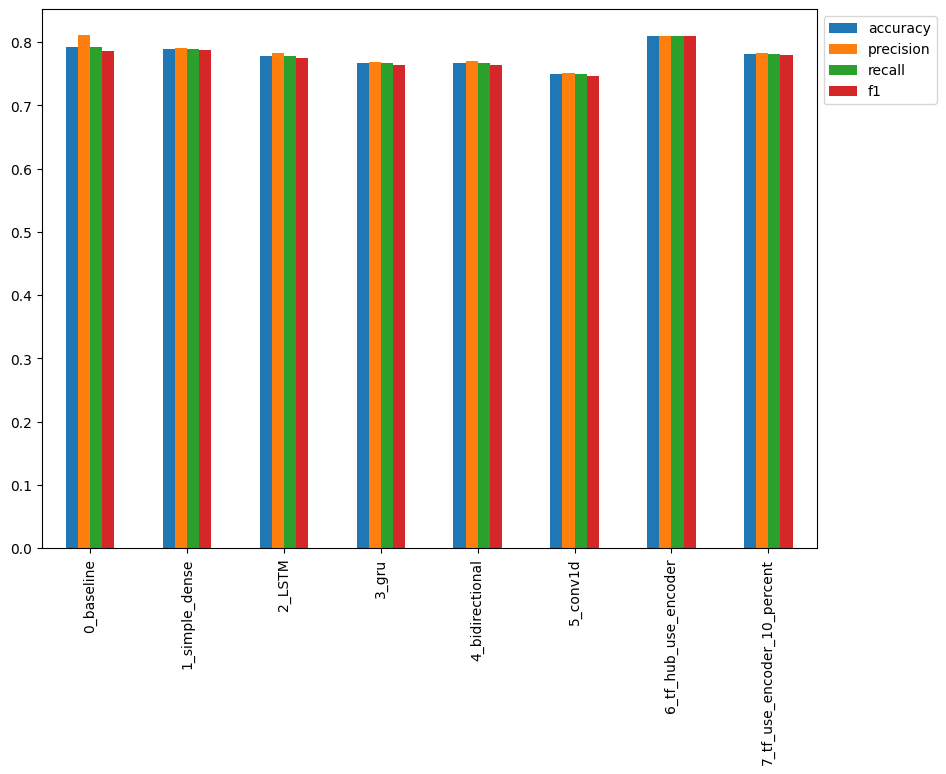

In [ ]:
# Plot and compare all of the models results
all_model_results.plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0)); # Move the legend

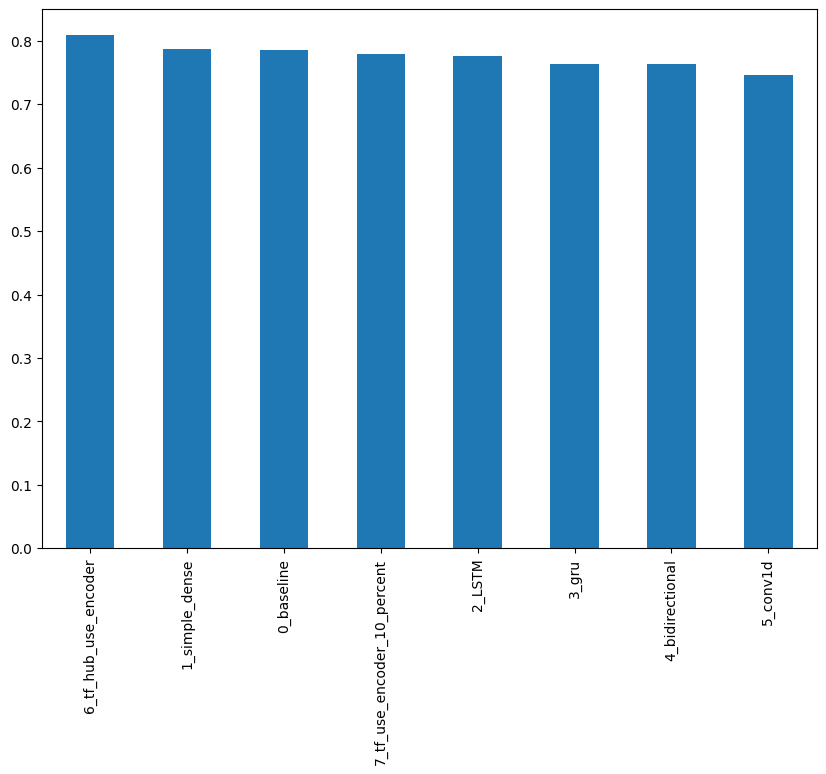

In [ ]:
# Sort model results by f1-score
all_model_results.sort_values("f1", ascending=False)["f1"].plot(kind="bar", figsize=(10, 7));

# Uploading our model training logs to TensorBoard.dev
We can further inspect our model's performance using TensorBoard.dev: https://tensorboard.dev/

In [ ]:
# View TensorBoard logs of transfer learning experiments (plus all of our other models)
# Upload TensorBoard dev records
!tensorboard dev upload --logdir ./drive/MyDrive/nlp_tweets/model_logs \
 --name "NLP modelling Experiments ZTM course Video" \
 --description "Comparing multiple different types of model architectures on the Kaggle Tweets text classification dataset" \
 --one_shot # Exits the uploader 

2023-05-30 13:33:31.377082: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

./drive/MyDrive/nlp_tweets/model_logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) NO


My modelling experiments are visable on TensorBoard at:
https://tensorboard.dev/experiment/da9otmPcRzaPNA19RGGOZQ/#scalars

> 📖 **Resource:** TensorBoard is great for quickly tracking experiments but for larger sclae experiments and a whole bunch more tracking options, check out Weights and Biases: https://wandb.ai/site

In [ ]:
## Saving and loading a trained model
from course_ztm import save_model, load_model

## Finding the most wrong examples

* If our best model still isn't perfect, what examples is it getting wrong ?
* And of these wrong examples which ones is it getting *most* wrong (those with prediction probabilities closest to the opposite class)



In [ ]:
# Download a pretrained model from Google Storage
!wget https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
!unzip 08_model_6_USE_feature_extractor.zip

--2023-05-30 14:20:57--  https://storage.googleapis.com/ztm_tf_course/08_model_6_USE_feature_extractor.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.153.128, 142.250.145.128, 74.125.128.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.153.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 960779165 (916M) [application/zip]
Saving to: ‘08_model_6_USE_feature_extractor.zip’

08_model_6_USE_feat 100%[===================>] 916.27M  31.9MB/s    in 31s     

2023-05-30 14:21:29 (29.3 MB/s) - ‘08_model_6_USE_feature_extractor.zip’ saved [960779165/960779165]

Archive:  08_model_6_USE_feature_extractor.zip
   creating: 08_model_6_USE_feature_extractor/
   creating: 08_model_6_USE_feature_extractor/assets/
   creating: 08_model_6_USE_feature_extractor/variables/
  inflating: 08_model_6_USE_feature_extractor/variables/variables.data-00000-of-00001  
  inflating: 08_model_6_USE_feature_extractor/variables/variable

In [ ]:
# Import previously trained model from Google Storage
model_6_pretrained = tf.keras.models.load_model("08_model_6_USE_feature_extractor")
model_6_pretrained.evaluate(val_sentences, val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.4272 - accuracy: 0.8163


[0.42723122239112854, 0.8162729740142822]

In [ ]:
# Make predictions with the loaded model from GS
model_6_pretrained_pred_prob = tf.squeeze(model_6_pretrained.predict(val_sentences))
model_6_pretrained_preds = tf.round(model_6_pretrained_pred_prob)
model_6_pretrained_preds[:10]

24/24 [==============================] - 1s 10ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
val_df = pd.DataFrame({"text": val_sentences,
                       "target": val_labels,
                       "pred": model_6_pretrained_preds,
                       "pred_prob": model_6_pretrained_pred_prob})
val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.159757
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.988749
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
4,Radiation emergency #preparedness starts with ...,1,1.0,0.707808


In [ ]:
# Find the wrong predictions
val_df_wrong = val_df[val_df["target"] != val_df["pred"]]
val_df_wrong

,text,target,pred,pred_prob
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.747162
3,@camilacabello97 Internally and externally scr...,1,0.0,0.196229
10,@RedCoatJackpot *As it was typical for them th...,0,1.0,0.586529
11,The Five Fatal Flaws in the Iran Deal https://...,0,1.0,0.504344
17,there's this person &amp; they reckon when you...,0,1.0,0.579814
...,...,...,...,...
744,Toddler drowned in bath after mum left room to...,1,0.0,0.343542
745,#ClimateChange Eyewitness to Extreme Weather: ...,1,0.0,0.387235
751,@emmerdale can we have a public vote for the n...,1,0.0,0.364633
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982


In [ ]:
# Sort the wrong predictions by prediction probabilities
val_df_wrong_sorted = val_df_wrong.sort_values("pred_prob", ascending=False)
val_df_wrong_sorted[:10]

,text,target,pred,pred_prob
31,? High Skies - Burning Buildings ? http://t.co...,0,1.0,0.910196
759,FedEx will no longer transport bioterror patho...,0,1.0,0.876982
628,@noah_anyname That's where the concentration c...,0,1.0,0.852300
209,Ashes 2015: AustraliaÛªs collapse at Trent Br...,0,1.0,0.835455
251,@AshGhebranious civil rights continued in the ...,0,1.0,0.827213
393,@SonofLiberty357 all illuminated by the bright...,0,1.0,0.814816
109,[55436] 1950 LIONEL TRAINS SMOKE LOCOMOTIVES W...,0,1.0,0.810840
49,@madonnamking RSPCA site multiple 7 story high...,0,1.0,0.803122
119,@freefromwolves GodsLove &amp; #thankU brother...,0,1.0,0.766901
344,Air Group is here to the rescue! We have 24/7 ...,0,1.0,0.766625


In [ ]:
val_df_wrong_sorted.tail()

,text,target,pred,pred_prob
411,@SoonerMagic_ I mean I'm a fan but I don't nee...,1,0.0,0.043918
233,I get to smoke my shit in peace,1,0.0,0.042087
38,Why are you deluged with low self-image? Take ...,1,0.0,0.038998
244,Reddit Will Now QuarantineÛ_ http://t.co/pkUA...,1,0.0,0.038949
23,Ron &amp; Fez - Dave's High School Crush https...,1,0.0,0.037186


In [ ]:
# Get class_names
class_names = ["not_disaster", "disaster"]

In [ ]:
# Check the false positives (model predicted 1 when should have been 0)
for row in val_df_wrong_sorted[:10].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target:{class_names[int(target)]}, Pred:{class_names[int(pred)]}, Pred_prob:{pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target:not_disaster, Pred:disaster, Pred_prob:0.9101957082748413
Text:
? High Skies - Burning Buildings ? http://t.co/uVq41i3Kx2 #nowplaying

----

Target:not_disaster, Pred:disaster, Pred_prob:0.8769820928573608
Text:
FedEx will no longer transport bioterror pathogens in wake of anthrax lab mishaps http://t.co/lHpgxc4b8J

----

Target:not_disaster, Pred:disaster, Pred_prob:0.8523001074790955
Text:
@noah_anyname That's where the concentration camps and mass murder come in. 
 
EVERY. FUCKING. TIME.

----

Target:not_disaster, Pred:disaster, Pred_prob:0.8354545831680298
Text:
Ashes 2015: AustraliaÛªs collapse at Trent Bridge among worst in history: England bundled out Australia for 60 ... http://t.co/t5TrhjUAU0

----

Target:not_disaster, Pred:disaster, Pred_prob:0.8272131681442261
Text:
@AshGhebranious civil rights continued in the 60s. And what about trans-generational trauma? if anything we should listen to the Americans.

----

Target:not_disaster, Pred:disaster, Pred_prob:0.8148159

In [ ]:
# Check the false negatives (model predicted 1 when should have been 0)
for row in val_df_wrong_sorted[-10:].itertuples():
  _, text, target, pred, pred_prob = row
  print(f"Target:{class_names[int(target)]}, Pred:{class_names[int(pred)]}, Pred_prob:{pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Target:disaster, Pred:not_disaster, Pred_prob:0.06730344146490097
Text:
@DavidVonderhaar At least you were sincere ??

----

Target:disaster, Pred:not_disaster, Pred_prob:0.055075839161872864
Text:
@willienelson We need help! Horses will die!Please RT &amp; sign petition!Take a stand &amp; be a voice for them! #gilbert23 https://t.co/e8dl1lNCVu

----

Target:disaster, Pred:not_disaster, Pred_prob:0.05460338667035103
Text:
Lucas Duda is Ghost Rider. Not the Nic Cage version but an actual 'engulfed in flames' badass. #Mets

----

Target:disaster, Pred:not_disaster, Pred_prob:0.05459698662161827
Text:
going to redo my nails and watch behind the scenes of desolation of smaug ayyy

----

Target:disaster, Pred:not_disaster, Pred_prob:0.04963728412985802
Text:
You can never escape me. Bullets don't harm me. Nothing harms me. But I know pain. I know pain. Sometimes I share it. With someone like you.

----

Target:disaster, Pred:not_disaster, Pred_prob:0.04391849413514137
Text:
@SoonerMagic_ I 

##Making predictions on the test dataset

In [ ]:
# Create test_sentences
test_sentences = test_df["text"].to_numpy() #(or .tolist())
test_sentences

array(['Just happened a terrible car crash',
       'Heard about #earthquake is different cities, stay safe everyone.',
       'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
       ..., 'Green Line derailment in Chicago http://t.co/UtbXLcBIuY',
       'MEG issues Hazardous Weather Outlook (HWO) http://t.co/3X6RBQJHn3',
       '#CityofCalgary has activated its Municipal Emergency Plan. #yycstorm'],
      dtype=object)

In [ ]:
# Make prediction for test set
model_6_pretrained_test_pred_prob = tf.squeeze(model_6_pretrained.predict(test_sentences))
model_6_pretrained_test_preds = tf.round(model_6_pretrained_test_pred_prob)
model_6_pretrained_test_preds[:10]

102/102 [==============================] - 1s 8ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>

In [ ]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
test_df = pd.DataFrame({"text": test_sentences,
                       "pred": model_6_pretrained_test_preds,
                       "pred_prob": model_6_pretrained_test_pred_prob})
test_df.head()

,text,pred,pred_prob
0,Just happened a terrible car crash,1.0,0.519970
1,"Heard about #earthquake is different cities, s...",1.0,0.875251
2,"there is a forest fire at spot pond, geese are...",1.0,0.827833
3,Apocalypse lighting. #Spokane #wildfires,1.0,0.933507
4,Typhoon Soudelor kills 28 in China and Taiwan,1.0,0.967958


In [ ]:
# Choose random number
i = random.randint(0,len(test_df)-10)
# Check 10 results
for row in test_df[i:i+10].itertuples():
  _, text, pred, pred_prob = row
  print(f"Pred:{class_names[int(pred)]}, Pred_prob:{pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Pred:not_disaster, Pred_prob:0.20245875418186188
Text:
@We3forDemocracy it already happens. ABs and rowers tweeting support for Nats last year and the deluge of celeb endorsements for Obama in 08

----

Pred:not_disaster, Pred_prob:0.32856130599975586
Text:
@CIOstrategyAU - As applicable to business as to warfare: 'battles of the future will be decided by #data' https://t.co/CIQsKWgdjj

----

Pred:not_disaster, Pred_prob:0.12613828480243683
Text:
Euro Ensembles much more optimistic for the weekend even though their operational counterpart is a deluge!

----

Pred:disaster, Pred_prob:0.6789460182189941
Text:
I'm havin previous life flashbacks of when i lived in Weimar Berlin. the hustlin life on Unter der Linden before the deluge.

----

Pred:not_disaster, Pred_prob:0.3415473699569702
Text:
#BigData Deluge is out! http://t.co/khatZh7agZ

----

Pred:disaster, Pred_prob:0.7531940340995789
Text:
A decade-long billion-dollar deluge of 'messages' from the government of Canada. #HarpersLegacy

## Your challenge... predicting on Tweets from the wild
Go to your favorite twitter account and copy one of their latest Tweets.
Then pass that Tweet through our trained model.
Is that Tweet a disaster or not disaster (according to the model)? 
Is the model right or wrong ?

In [ ]:
# Make prediction for a custom set
custom_sentences = ["There is a fire in the hall", "I am going on holliday", "I will fly", "A lot of people have died", "emmergency earthquake", "there is flood in town", "red alert in here", "terrorist attack in downtown", "two men attack a church with guns", "great show on tv tonight"]
model_6_pretrained_custom_pred_prob = tf.squeeze(model_6_pretrained.predict(custom_sentences))
model_6_pretrained_custom_preds = tf.round(model_6_pretrained_custom_pred_prob)
model_6_pretrained_custom_preds[:10]

1/1 [==============================] - 0s 34ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 0., 0., 0., 1., 1., 0., 1., 1., 0.], dtype=float32)>

In [ ]:
# Create DataFrame with validation sentences, validation labels and best performing model prediction labels + probabilities
custom_df = pd.DataFrame({"text": custom_sentences,
                       "pred": model_6_pretrained_custom_preds,
                       "pred_prob": model_6_pretrained_custom_pred_prob})
custom_df.head()

,text,pred,pred_prob
0,There is a fire in the hall,0.0,0.328630
1,I am going on holliday,0.0,0.116811
2,I will fly,0.0,0.077850
3,A lot of people have died,0.0,0.277878
4,emmergency earthquake,1.0,0.835116


In [ ]:
# Check results
for row in custom_df.itertuples():
  _, text, pred, pred_prob = row
  print(f"Pred:{class_names[int(pred)]}, Pred_prob:{pred_prob}")
  print(f"Text:\n{text}\n")
  print("----\n")

Pred:not_disaster, Pred_prob:0.32862967252731323
Text:
There is a fire in the hall

----

Pred:not_disaster, Pred_prob:0.11681093275547028
Text:
I am going on holliday

----

Pred:not_disaster, Pred_prob:0.07785028964281082
Text:
I will fly

----

Pred:not_disaster, Pred_prob:0.27787840366363525
Text:
A lot of people have died

----

Pred:disaster, Pred_prob:0.8351163268089294
Text:
emmergency earthquake

----

Pred:disaster, Pred_prob:0.5104795098304749
Text:
there is flood in town

----

Pred:not_disaster, Pred_prob:0.14494632184505463
Text:
red alert in here

----

Pred:disaster, Pred_prob:0.9390062093734741
Text:
terrorist attack in downtown

----

Pred:disaster, Pred_prob:0.7451794743537903
Text:
two men attack a church with guns

----

Pred:not_disaster, Pred_prob:0.048972755670547485
Text:
great show on tv tonight

----



## The speed/score tradeoff

In [ ]:
# Let's make a function to measure the time of prediction
import time
def pred_timer(model, samples):
  """
  Times how long a model takes to make predictions on samples.
  """
  start_time = time.perf_counter() # get start time
  model.predict(samples)
  end_time = time.perf_counter()
  total_time = end_time - start_time
  time_per_pred = total_time/len(samples)
  return total_time, time_per_pred

In [ ]:
# Calculate TF Hub Sentence Encoder time per pred
model_6_total_pred_time, model_6_time_per_pred = pred_timer(model= model_6_pretrained,
                                                            samples=val_sentences)
model_6_total_pred_time, model_6_time_per_pred

24/24 [==============================] - 0s 5ms/step


(0.1895529080002234, 0.00024875709711315406)

In [ ]:
# Calculate our baseline model times per pred
baseline_total_pred_time, baseline_time_per_pred = pred_timer(model_0, val_sentences)
baseline_total_pred_time, baseline_time_per_pred

(0.02005009799995605, 2.6312464566871458e-05)

In [ ]:
# Get results for pretrained GS model 
model_6_pretrained_results = calculate_results(y_true=val_labels,
                                               y_pred=model_6_pretrained_preds)
model_6_pretrained_results

{'accuracy': 81.62729658792651,
 'precision': 0.818446310697231,
 'recall': 0.8162729658792651,
 'f1': 0.8148082644367335}

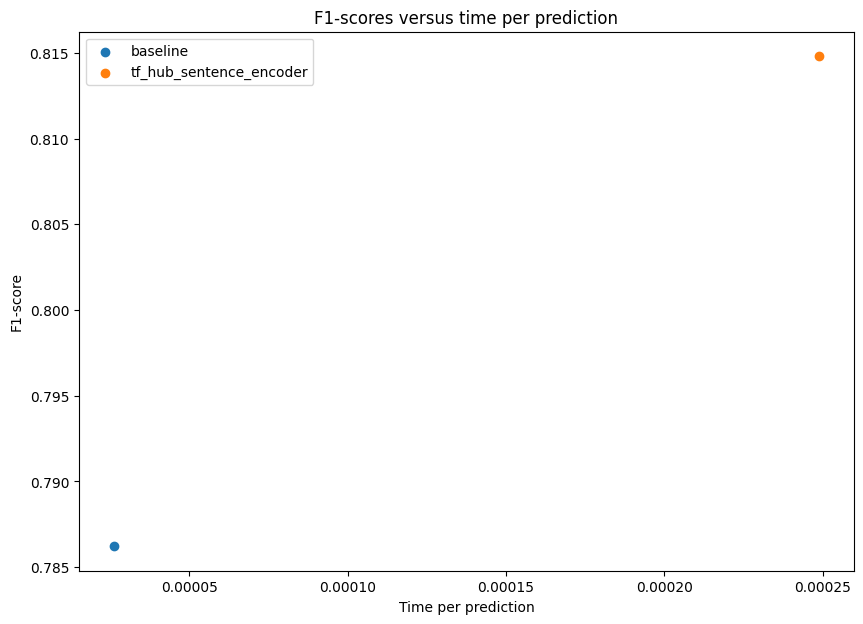

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))
plt.scatter(baseline_time_per_pred, baseline_results["f1"], label="baseline")
plt.scatter(model_6_time_per_pred, model_6_pretrained_results["f1"], label="tf_hub_sentence_encoder")
plt.legend()
plt.title("F1-scores versus time per prediction")
plt.xlabel("Time per prediction")
plt.ylabel("F1-score");

## 🛠 08. Introduction to NLP (Natural Language Processing) in TensorFlow Exercises
1. Rebuild, compile and train `model_1`, `model_2` and `model_5` using the [Keras Sequential API](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) instead of the Functional API.
2. Retrain the baseline model with 10% of the training data. How does perform compared to the Universal Sentence Encoder model with 10% of the training data?
3. Try fine-tuning the TF Hub Universal Sentence Encoder model by setting `training=True` when instantiating it as a Keras layer.

```
# We can use this encoding layer in place of our text_vectorizer and embedding layer
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model
```
4. Retrain the best model you've got so far on the whole training set (no validation split). Then use this trained model to make predictions on the test dataset and format the predictions into the same format as the `sample_submission.csv` file from Kaggle (see the Files tab in Colab for what the `sample_submission.csv` file looks like). Once you've done this, [make a submission to the Kaggle competition](https://www.kaggle.com/c/nlp-getting-started/data), how did your model perform?
5. Combine the ensemble predictions using the majority vote (mode), how does this perform compare to averaging the prediction probabilities of each model?
6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

In [ ]:
# 1. Rebuild, compile and train model_1, model_2 and model_5
# from numpy.core.fromnumeric import shape
# # Build model with the functional API
# from tensorflow.keras import layers
# inputs = layers.Input(shape=(1,), dtype="string") # inputs are 1-dimensional strings
# x = text_vectorizer(inputs) # turn the input text into numbers
# x = embedding(x) # Create an embedding of the numberized inputs
# x = layers.GlobalMaxPool1D()(x)
# outputs = layers.Dense(1, activation="sigmoid")(x) # Create the output layer, want binary outputs so use sigmoïd activation function.
# model_1 = tf.keras.Model(inputs, outputs, name="model_1_dense")

In [ ]:
text_vectorization = layers.TextVectorization(max_tokens=max_vocab_length,
                                              output_mode="int",
                                              output_sequence_length=max_length,
                                              )
text_vectorization.adapt(train_sentences)

In [ ]:
# Model 1 in sequential
model_1_seq = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype="string"),
    text_vectorization,
    layers.Embedding(input_dim=max_vocab_length, # set input shape
                     output_dim=128, # neural networks work very well with numbers that are divisible by 8.
                     input_length=max_length # how long is each imput
                             ),
    layers.GlobalMaxPool1D(),
    layers.Dense(1, activation="sigmoid")                       
], name="model_1_dense_seq") 

Let's compare our layers between sequential and functional 

In [ ]:
model_1_seq.summary()

Model: "model_1_dense_seq"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_2 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_7 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model_1.summary()

Model: "model_1_dense"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 15)               0         
 ectorization)                                                   
                                                                 
 embedding (Embedding)       (None, 15, 128)           1280000   
                                                                 
 global_max_pooling1d (Globa  (None, 128)              0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 1)                 129       
                                                                 
Total params: 1,280,129
Trainable params: 1,280,129
N

In [ ]:
# Compile model
model_1_seq.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])  

In [ ]:
# Fit the model
model_1_history_seq = model_1_seq.fit(train_sentences,
                                      train_labels,
                                      epochs=5,
                                      validation_data=(val_sentences, val_labels),
                                      callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                             experiment_name="model_1_dense")])

Saving TensorBoard log files to: drive/MyDrive/nlp_tweets/model_logs/model_1_dense/20230530-162156
Epoch 1/5
215/215 [==============================] - 3s 10ms/step - loss: 0.6406 - accuracy: 0.6701 - val_loss: 0.5779 - val_accuracy: 0.7493
Epoch 2/5
215/215 [==============================] - 2s 9ms/step - loss: 0.4737 - accuracy: 0.8243 - val_loss: 0.4754 - val_accuracy: 0.7861
Epoch 3/5
215/215 [==============================] - 2s 8ms/step - loss: 0.3439 - accuracy: 0.8737 - val_loss: 0.4551 - val_accuracy: 0.7900
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2605 - accuracy: 0.9082 - val_loss: 0.4520 - val_accuracy: 0.7822
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1998 - accuracy: 0.9343 - val_loss: 0.4673 - val_accuracy: 0.7861


In [ ]:
# Calculate model 1 seq preds
model_1_seq_pred_probs = model_1_seq.predict(val_sentences)
model_1_seq_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.41221493],
       [0.8892155 ],
       [0.9952025 ],
       [0.06438015],
       [0.25492877],
       [0.9685396 ],
       [0.93990934],
       [0.9917176 ],
       [0.925631  ],
       [0.10172243]], dtype=float32)

In [ ]:
# Convert model_6 pred probs to labels
model_1_seq_preds = tf.squeeze(tf.round(model_1_seq_pred_probs))
model_1_seq_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_1_seq results
model_1_seq_results = calculate_results(y_true=val_labels,
                                        y_pred=model_1_seq_preds)
model_1_seq_results

{'accuracy': 78.60892388451444,
 'precision': 0.7899352475221245,
 'recall': 0.7860892388451444,
 'f1': 0.7834372696728737}

In [ ]:
# Model 2 in sequential
model_2_seq = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype="string"),
    text_vectorization,
    layers.Embedding(input_dim=max_vocab_length, # set input shape
                     output_dim=128, # neural networks work very well with numbers that are divisible by 8.
                     input_length=max_length # how long is each imput
                             ),
    layers.LSTM(64),
    layers.Dense(1, activation="sigmoid")                       
], name="model_2_dense_seq") 

In [ ]:
# Compile model
model_2_seq.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])  

In [ ]:
# Fit the model
model_2_history_seq = model_2_seq.fit(train_sentences,
                                      train_labels,
                                      epochs=5,
                                      validation_data=(val_sentences, val_labels),
                                      callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                             experiment_name="model_2_dense")])

Saving TensorBoard log files to: drive/MyDrive/nlp_tweets/model_logs/model_2_dense/20230530-162218
Epoch 1/5
215/215 [==============================] - 6s 19ms/step - loss: 0.5062 - accuracy: 0.7519 - val_loss: 0.4536 - val_accuracy: 0.7848
Epoch 2/5
215/215 [==============================] - 4s 16ms/step - loss: 0.3188 - accuracy: 0.8721 - val_loss: 0.5072 - val_accuracy: 0.7743
Epoch 3/5
215/215 [==============================] - 5s 21ms/step - loss: 0.2194 - accuracy: 0.9181 - val_loss: 0.5554 - val_accuracy: 0.7743
Epoch 4/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1554 - accuracy: 0.9438 - val_loss: 0.6627 - val_accuracy: 0.7625
Epoch 5/5
215/215 [==============================] - 4s 17ms/step - loss: 0.1101 - accuracy: 0.9588 - val_loss: 0.8791 - val_accuracy: 0.7730


In [ ]:
# Calculate model 2 seq preds
model_2_seq_pred_probs = model_2_seq.predict(val_sentences)
model_2_seq_pred_probs[:10]

24/24 [==============================] - 0s 4ms/step


array([[0.8792939 ],
       [0.73474807],
       [0.9993569 ],
       [0.0316555 ],
       [0.00281077],
       [0.99920833],
       [0.8153416 ],
       [0.9997948 ],
       [0.9997152 ],
       [0.20765391]], dtype=float32)

In [ ]:
# Convert model_2 pred probs to labels
model_2_seq_preds = tf.squeeze(tf.round(model_2_seq_pred_probs))
model_2_seq_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_2_seq results
model_2_seq_results = calculate_results(y_true=val_labels,
                                        y_pred=model_2_seq_preds)
model_2_seq_results

{'accuracy': 77.29658792650919,
 'precision': 0.77365375135567,
 'recall': 0.7729658792650919,
 'f1': 0.77144803030122}

In [ ]:
# Model 5 in sequential
model_5_seq = tf.keras.Sequential([
    tf.keras.Input(shape=(1,), dtype="string"),
    text_vectorization,
    layers.Embedding(input_dim=max_vocab_length, # set input shape
                     output_dim=128, # neural networks work very well with numbers that are divisible by 8.
                     input_length=max_length # how long is each imput
                             ),
    layers.Conv1D(64,
                  5,
                  activation="relu",
                  padding="valid"),
    layers.Dense(1, activation="sigmoid"),
    layers.GlobalMaxPool1D()                       
], name="model_2_dense_seq") 

In [ ]:
# Compile model
model_5_seq.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])  

In [ ]:
# Fit the model
model_5_history_seq = model_5_seq.fit(train_sentences,
                                      train_labels,
                                      epochs=5,
                                      validation_data=(val_sentences, val_labels),
                                      callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                             experiment_name="model_5_dense")])

Saving TensorBoard log files to: drive/MyDrive/nlp_tweets/model_logs/model_5_dense/20230530-162240
Epoch 1/5
215/215 [==============================] - 4s 16ms/step - loss: 0.5727 - accuracy: 0.7050 - val_loss: 0.4868 - val_accuracy: 0.7756
Epoch 2/5
215/215 [==============================] - 2s 11ms/step - loss: 0.3548 - accuracy: 0.8535 - val_loss: 0.5147 - val_accuracy: 0.7730
Epoch 3/5
215/215 [==============================] - 2s 11ms/step - loss: 0.2375 - accuracy: 0.9101 - val_loss: 0.5828 - val_accuracy: 0.7651
Epoch 4/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1638 - accuracy: 0.9412 - val_loss: 0.6268 - val_accuracy: 0.7717
Epoch 5/5
215/215 [==============================] - 2s 11ms/step - loss: 0.1266 - accuracy: 0.9550 - val_loss: 0.7330 - val_accuracy: 0.7625


In [ ]:
# Calculate model 5 seq preds
model_5_seq_pred_probs = model_5_seq.predict(val_sentences)
model_5_seq_pred_probs[:10]

24/24 [==============================] - 0s 2ms/step


array([[0.17023712],
       [0.8913393 ],
       [0.9974423 ],
       [0.00726831],
       [0.03926589],
       [0.9753893 ],
       [0.9907088 ],
       [0.9990032 ],
       [0.9088359 ],
       [0.02422595]], dtype=float32)

In [ ]:
# Convert model_5 pred probs to labels
model_5_seq_preds = tf.squeeze(tf.round(model_5_seq_pred_probs))
model_5_seq_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_5_seq results
model_5_seq_results = calculate_results(y_true=val_labels,
                                        y_pred=model_5_seq_preds)
model_5_seq_results

{'accuracy': 76.24671916010499,
 'precision': 0.7724446120881597,
 'recall': 0.7624671916010499,
 'f1': 0.7567931057798104}

2. Retrain the baseline model with 10% of the training data

In [ ]:
# Fit the pipeline to the training data
model_0.fit(train_sentences_10_percent, train_labels_10_percent)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [ ]:
# Evaluate our baseline model
baseline_score = model_0.score(val_sentences, val_labels)
print(f"Our baseline model achieves an accuracy of: {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of: 70.21%


In [ ]:
# Calculate model baseline preds
model_0_retrain_pred_probs = model_0.predict(val_sentences)
model_0_retrain_pred_probs[:10]

array([1, 0, 1, 0, 0, 1, 0, 0, 1, 0])

In [ ]:
# Calculate model_5_seq results
model_0_retrain_results = calculate_results(y_true=val_labels,
                                            y_pred=model_0_retrain_pred_probs)
model_0_retrain_results

{'accuracy': 70.20997375328083,
 'precision': 0.7599524002753854,
 'recall': 0.7020997375328084,
 'f1': 0.6736831571468213}

In [ ]:
# Compare to the USE model with 10% of the training
model_7_results_10_percent

{'accuracy': 78.08398950131233,
 'precision': 0.7818764826324955,
 'recall': 0.7808398950131233,
 'f1': 0.7792643495521726}

3. Try fine-tuning the TF Hub Universal Sentence Encoder model

In [ ]:
# Unfreeze the layers
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True) # turn training on to fine-tune the TensorFlow Hub model

In [ ]:
# Compile 
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(0.0001),
                metrics=["accuracy"])

In [ ]:
# Start to fine-tune (all layers)
# Use 5 epochs as the default
initial_epoch = 5
fine_tune_epochs = initial_epoch + 5
model_6_history_fine_tuning = model_6.fit(train_sentences,
                                          train_labels,
                                          epochs=fine_tune_epochs,
                                          validation_data=(val_sentences, val_labels),
                                          validation_steps=len(val_sentences),
                                          initial_epoch=model_6_history.epoch[-1], 
                                          callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR, 
                                                                                 experiment_name="tf_hub_sentence_encoder_fine_tuning")])

Saving TensorBoard log files to: drive/MyDrive/nlp_tweets/model_logs/tf_hub_sentence_encoder_fine_tuning/20230530-162313
Epoch 5/10
215/215 [==============================] - 6s 21ms/step - loss: 0.3722 - accuracy: 0.8370 - val_loss: 0.4254 - val_accuracy: 0.8163
Epoch 6/10
215/215 [==============================] - 5s 23ms/step - loss: 0.3703 - accuracy: 0.8378 - val_loss: 0.4260 - val_accuracy: 0.8150
Epoch 7/10
215/215 [==============================] - 4s 19ms/step - loss: 0.3694 - accuracy: 0.8390 - val_loss: 0.4255 - val_accuracy: 0.8176
Epoch 8/10
215/215 [==============================] - 3s 15ms/step - loss: 0.3685 - accuracy: 0.8387 - val_loss: 0.4249 - val_accuracy: 0.8176
Epoch 9/10
215/215 [==============================] - 7s 30ms/step - loss: 0.3677 - accuracy: 0.8408 - val_loss: 0.4249 - val_accuracy: 0.8176
Epoch 10/10
215/215 [==============================] - 3s 15ms/step - loss: 0.3670 - accuracy: 0.8389 - val_loss: 0.4249 - val_accuracy: 0.8176


In [ ]:
# Calculate model 6 fine tune seq preds
model_6_fine_tune_seq_pred_probs = model_6.predict(val_sentences)
model_6_fine_tune_seq_pred_probs[:10]

24/24 [==============================] - 0s 6ms/step


array([[0.18083319],
       [0.8051025 ],
       [0.9919513 ],
       [0.22322804],
       [0.7325062 ],
       [0.72491604],
       [0.9853298 ],
       [0.98352915],
       [0.94764334],
       [0.08970343]], dtype=float32)

In [ ]:
# Convert model_6 fine tune pred probs to labels
model_6_fine_tune_seq_preds = tf.squeeze(tf.round(model_6_fine_tune_seq_pred_probs))
model_6_fine_tune_seq_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
# Calculate model_5_seq results
model_6_fine_tune_seq_results = calculate_results(y_true=val_labels,
                                                  y_pred=model_6_fine_tune_seq_preds)
model_6_fine_tune_seq_results

{'accuracy': 81.75853018372703,
 'precision': 0.8196403099324437,
 'recall': 0.8175853018372703,
 'f1': 0.8161793631328899}

4. Retrain the best model you've got so far on the whole training set (no validation split).

In [ ]:
# Find the best model
# Combine model results into a DataFrame
all_model_results = pd.DataFrame({"0_baseline": baseline_results,
                                  "1_simple_dense": model_1_results,
                                  "2_LSTM": model_2_results,
                                  "3_gru": model_3_results,
                                  "4_bidirectional": model_4_results,
                                  "5_conv1d": model_5_results,
                                  "6_tf_hub_use_encoder": model_6_results,
                                  "7_tf_use_encoder_10_percent": model_7_results_10_percent,
                                  "8_simple_dense_seq": model_1_seq_results,
                                  "9_LSTM_seq": model_2_seq_results,
                                  "10_conv1d_seq": model_5_seq_results,
                                  "11_baseline_retrained": model_0_retrain_results,
                                  "12_tf_hub_use_encoder_fine_tune":model_6_fine_tune_seq_results})
all_model_results = all_model_results.transpose()
all_model_results.sort_values("f1", ascending=False)

,accuracy,precision,recall,f1
12_tf_hub_use_encoder_fine_tune,81.758530,0.819640,0.817585,0.816179
6_tf_hub_use_encoder,80.971129,0.809590,0.809711,0.809243
1_simple_dense,78.871391,0.790948,0.788714,0.786738
0_baseline,79.265092,0.811139,0.792651,0.786219
8_simple_dense_seq,78.608924,0.789935,0.786089,0.783437
7_tf_use_encoder_10_percent,78.083990,0.781876,0.780840,0.779264
2_LSTM,77.821522,0.782141,0.778215,0.775320
9_LSTM_seq,77.296588,0.773654,0.772966,0.771448
3_gru,76.640420,0.768433,0.766404,0.764015
4_bidirectional,76.640420,0.770042,0.766404,0.763277


Best model is `tf_hub_use_encoder_fine_tune`

In [ ]:
# Refreeze the layers
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False) # turn training on to fine-tune the TensorFlow Hub model

In [ ]:
# Recompile 
model_6.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [ ]:
# Fit the model on the whole training set
model_6_history_seq_full_train = model_6.fit(train_df_shuffled["text"].to_numpy(),
                                             train_df_shuffled["target"].to_numpy(),
                                             epochs=5,
                                             callbacks=[create_tensorboard_callback(dir_name=SAVE_DIR,
                                                                                    experiment_name="model_5_dense")])

Saving TensorBoard log files to: drive/MyDrive/nlp_tweets/model_logs/model_5_dense/20230530-162347
Epoch 1/5
238/238 [==============================] - 3s 7ms/step - loss: 0.3793 - accuracy: 0.8328
Epoch 2/5
238/238 [==============================] - 2s 7ms/step - loss: 0.3710 - accuracy: 0.8374
Epoch 3/5
238/238 [==============================] - 2s 8ms/step - loss: 0.3665 - accuracy: 0.8376
Epoch 4/5
238/238 [==============================] - 2s 7ms/step - loss: 0.3592 - accuracy: 0.8437
Epoch 5/5
238/238 [==============================] - 2s 7ms/step - loss: 0.3521 - accuracy: 0.8462


In [ ]:
# Calculate model 6 seq full trains preds on test_df
model_6_seq_ft_pred_probs = model_6.predict(test_df["text"].to_numpy())
model_6_seq_ft_pred_probs[:10]

102/102 [==============================] - 1s 10ms/step


array([[0.6739377 ],
       [0.94482857],
       [0.83707875],
       [0.9447683 ],
       [0.98659897],
       [0.5855885 ],
       [0.04647791],
       [0.01655391],
       [0.03521245],
       [0.03299027]], dtype=float32)

In [ ]:
# Convert model 6 seq full trains pred probs to labels
model_6_fine_tune_seq_preds = tf.cast(tf.squeeze(tf.round(model_6_seq_ft_pred_probs)), tf.int32)
model_6_fine_tune_seq_preds[:10]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0], dtype=int32)>

In [ ]:
# Convert into dataframe
tweets_df = pd.DataFrame({"id": test_df.index,
                          "target":model_6_fine_tune_seq_preds})
tweets_df

,id,target
0,0,1
1,1,1
2,2,1
3,3,1
4,4,1
...,...,...
3258,3258,1
3259,3259,1
3260,3260,1
3261,3261,1


In [ ]:
# Export dataframe
tweets_df.to_csv("/content/drive/MyDrive/nlp_tweets/tweets_df.csv", index = False)

6. Make a confusion matrix with the best performing model's predictions on the validation set and the validation ground truth labels.

In [ ]:
# Import confusion matrix function
from course_ztm import make_confusion_matrix

In [ ]:
# Calculate model 6 probs on validation set
model_6_validation_probs = model_6.predict(val_sentences)
model_6_validation_probs[:10]

NameError: ignored

In [ ]:
# Convert model 6 validation probs to preds
model_6_validation_preds = tf.cast(tf.squeeze(tf.round(model_6_validation_probs)), tf.int32)
model_6_validation_preds[:10]

<tf.Tensor: shape=(10,), dtype=int32, numpy=array([0, 1, 1, 0, 1, 1, 1, 1, 1, 0], dtype=int32)>

In [ ]:
make_confusion_matrix(val_labels, 
                      model_6_validation_preds, 
                      class_names, 
                      (250, 100),
                      20,
                      True)

NameError: ignored

## 📖 08. Introduction to NLP (Natural Language Processing) in TensorFlow Extra-curriculum
To practice what you've learned, a good idea would be to spend an hour on 3 of the following (3-hours total, you could through them all if you want) and then write a blog post about what you've learned.

* For an overview of the different problems within NLP and how to solve them read through: 
  * [A Simple Introduction to Natural Language Processing](https://becominghuman.ai/a-simple-introduction-to-natural-language-processing-ea66a1747b32)
  * [How to solve 90% of NLP problems: a step-by-step guide](https://blog.insightdatascience.com/how-to-solve-90-of-nlp-problems-a-step-by-step-guide-fda605278e4e)
* Go through [MIT's Recurrent Neural Networks lecture](https://youtu.be/SEnXr6v2ifU). This will be one of the greatest additions to what's happening behind the RNN model's you've been building.
* Read through the [word embeddings page on the TensorFlow website](https://www.tensorflow.org/tutorials/text/word_embeddings). Embeddings are such a large part of NLP. We've covered them throughout this notebook but extra practice would be well worth it. A good exercise would be to write out all the code in the guide in a new notebook. 
* For more on RNN's in TensorFlow, read and reproduce [the TensorFlow RNN guide](https://www.tensorflow.org/guide/keras/rnn). We've covered many of the concepts in this guide, but it's worth writing the code again for yourself.
* Text data doesn't always come in a nice package like the data we've downloaded. So if you're after more on preparing different text sources for being with your TensorFlow deep learning models, it's worth checking out the following:
  * [TensorFlow text loading tutorial](https://www.tensorflow.org/tutorials/load_data/text).
  * [Reading text files with Python](https://realpython.com/read-write-files-python/) by Real Python.
* This notebook has focused on writing NLP code. For a mathematically rich overview of how NLP with Deep Learning happens, read [Stanford's Natural Language Processing with Deep Learning lecture notes Part 1](https://web.stanford.edu/class/cs224n/readings/cs224n-2019-notes01-wordvecs1.pdf).  
  * For an even deeper dive, you could even do the whole [CS224n](http://web.stanford.edu/class/cs224n/) (Natural Language Processing with Deep Learning) course. 
* Great blog posts to read:
  * Andrei Karpathy's [The Unreasonable Effectiveness of RNNs](https://karpathy.github.io/2015/05/21/rnn-effectiveness/) dives into generating Shakespeare text with RNNs.
  * [Text Classification with NLP: Tf-Idf vs Word2Vec vs BERT](https://towardsdatascience.com/text-classification-with-nlp-tf-idf-vs-word2vec-vs-bert-41ff868d1794) by Mauro Di Pietro. An overview of different techniques for turning text into numbers and then classifying it.
  * [What are word embeddings?](https://machinelearningmastery.com/what-are-word-embeddings/) by Machine Learning Mastery.
* Other topics worth looking into:
  * [Attention mechanisms](https://jalammar.github.io/visualizing-neural-machine-translation-mechanics-of-seq2seq-models-with-attention/). These are a foundational component of the transformer architecture and also often add improvements to deep NLP models.
  * [Transformer architectures](http://jalammar.github.io/illustrated-transformer/). This model architecture has recently taken the NLP world by storm, achieving state of the art on many benchmarks. However, it does take a little more processing to get off the ground, the [HuggingFace Models (formerly HuggingFace Transformers) library](https://huggingface.co/models/) is probably your best quick start.
